# Data Processing and EDA

<font color='red'> **PLEASE DO NOT RUN THIS NOTEBOOK!**</font>

<font color='red'>The files we worked with for the cleaning process were too large to push to Github, and therefore the filepaths in this notebook do not exist. However, we included this notebook to show our process for data cleaning and EDA.</font>

In [1]:
import gzip
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## load in raw data

The following code is how we read in the [raw data](https://amazon-reviews-2023.github.io/). The raw jsonl.gz file is too large to push to Github, and so we took only the subset of columns necessary for the training process, and transformed it into a csv file.

In [2]:
# DON'T RUN
# transform raw jsonl.gz file to a pandas dataframe

# df = pd.read_json('assets/All_Beauty.jsonl.gz', lines=True, compression='gzip')
# df = df[['user_id', 'parent_asin', 'timestamp']]
# df.to_csv('assets/beauty23_raw.csv', index = False)

In [3]:
df = pd.read_csv('assets/beauty23_raw.csv')
df

,user_id,parent_asin,timestamp
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,2020-05-05 14:08:48.923
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,2020-05-04 18:10:55.070
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,2020-05-16 21:41:06.052
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,2022-01-28 18:13:50.220
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,2020-12-30 10:02:43.534
...,...,...,...
701523,AFIXGFVEGLMOTMBTJL7H3VSIETDQ,B006YUIWKA,2016-11-04 02:37:01.000
701524,AFV7YZFOJF564EZGET5LG45K4QEA,B006YUIWKA,2016-12-05 03:32:10.000
701525,AHYDCWDMMVMLBX7FY7M7JKADKRDQ,B06ZZV9MZT,2020-05-27 02:52:54.067
701526,AF6ZIAEN7TQ2WY5ZL77F6JDPV7XQ,B000HB6VLE,2007-07-18 22:36:49.000


## data cleaning and processing

In [4]:
# rename columns for simplicity

df.columns = ['usr', 'prod', 'timestamp']
df

,usr,prod,timestamp
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,2020-05-05 14:08:48.923
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,2020-05-04 18:10:55.070
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,2020-05-16 21:41:06.052
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,2022-01-28 18:13:50.220
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,2020-12-30 10:02:43.534
...,...,...,...
701523,AFIXGFVEGLMOTMBTJL7H3VSIETDQ,B006YUIWKA,2016-11-04 02:37:01.000
701524,AFV7YZFOJF564EZGET5LG45K4QEA,B006YUIWKA,2016-12-05 03:32:10.000
701525,AHYDCWDMMVMLBX7FY7M7JKADKRDQ,B06ZZV9MZT,2020-05-27 02:52:54.067
701526,AF6ZIAEN7TQ2WY5ZL77F6JDPV7XQ,B000HB6VLE,2007-07-18 22:36:49.000


In [5]:
# change the `timestamp` column to unix time

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f').astype('int64') // 10**6
df

,usr,prod,timestamp
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,1588687728923
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,1588615855070
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,1589665266052
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,1643393630220
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,1609322563534
...,...,...,...
701523,AFIXGFVEGLMOTMBTJL7H3VSIETDQ,B006YUIWKA,1478227021000
701524,AFV7YZFOJF564EZGET5LG45K4QEA,B006YUIWKA,1480908730000
701525,AHYDCWDMMVMLBX7FY7M7JKADKRDQ,B06ZZV9MZT,1590547974067
701526,AF6ZIAEN7TQ2WY5ZL77F6JDPV7XQ,B000HB6VLE,1184798209000


### lower product frequency filtering

In [37]:
# LOWER PRODUCT FREQUENCY (>= 5) FILTERING

# follow filtering steps as outlined in paper:
# 1. keep only the products with 5 or more user interactions
# 2. then, keep only the users with 5 or more product interactions

min_user = 5
min_prod = 5

df5 = df.groupby('prod').filter(lambda x: x.shape[0] >= min_prod)
df5 = df5.groupby('usr').filter(lambda x: x.shape[0] >= min_user)
df5

,usr,prod,timestamp
8,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08P2DZB4X,1627391044559
9,AFSKPY37N3C43SOI5IEXEK5JSIYA,B086QY6T7N,1626614511145
11,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07RBSLNFR,1621184430697
12,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07SLFWZKN,1619737501209
13,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08JTNQFZY,1617904219785
...,...,...,...
695780,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
695781,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
695783,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
695785,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373


In [38]:
# for each user, order their products in ascending order by time

df5 = df5.groupby('usr', sort=False).apply(
    lambda x: x.sort_values('timestamp')
).reset_index(drop=True)
df5

/var/folders/2k/9mnd960x2j1d9b35wyjwwx200000gp/T/ipykernel_39845/706154118.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df5 = df5.groupby('usr', sort=False).apply(


,usr,prod,timestamp
0,AFSKPY37N3C43SOI5IEXEK5JSIYA,B00JMDPK8S,1404402463000
1,AFSKPY37N3C43SOI5IEXEK5JSIYA,B01M7UMAUG,1508770624887
2,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07J3GH1W1,1547589356557
3,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07GDQPG12,1547589843451
4,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07W397QG4,1593352422858
...,...,...,...
9484,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
9485,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
9486,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
9487,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373


In [39]:
# keep only the user and product columns

df5 = df5[['usr', 'prod']]
df5

,usr,prod
0,AFSKPY37N3C43SOI5IEXEK5JSIYA,B00JMDPK8S
1,AFSKPY37N3C43SOI5IEXEK5JSIYA,B01M7UMAUG
2,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07J3GH1W1
3,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07GDQPG12
4,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07W397QG4
...,...,...
9484,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ
9485,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ
9486,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ
9487,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ


In [40]:
# save file as csv

df5.to_csv('assets/beauty23_clean_5.csv', index = False)

### higher product frequency filtering

In [41]:
# HIGHER PRODUCT FREQUENCY (>= 7)

# 1. keep only the products with 7 or more user interactions
# 2. then, keep only the users with 5 or more product interactions

min_user = 5
min_prod = 7

df7 = df.groupby('prod').filter(lambda x: x.shape[0] >= min_prod)
df7 = df7.groupby('usr').filter(lambda x: x.shape[0] >= min_user)
df7

,usr,prod,timestamp
8,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08P2DZB4X,1627391044559
9,AFSKPY37N3C43SOI5IEXEK5JSIYA,B086QY6T7N,1626614511145
12,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07SLFWZKN,1619737501209
13,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08JTNQFZY,1617904219785
16,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07GHPCT6T,1598212476613
...,...,...,...
695780,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
695781,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
695783,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
695785,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373


In [42]:
# for each user, order their products in ascending order by time

df7 = df7.groupby('usr', sort=False).apply(
    lambda x: x.sort_values('timestamp')
).reset_index(drop=True)
df7

/var/folders/2k/9mnd960x2j1d9b35wyjwwx200000gp/T/ipykernel_39845/4150168136.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df7 = df7.groupby('usr', sort=False).apply(


,usr,prod,timestamp
0,AFSKPY37N3C43SOI5IEXEK5JSIYA,B00JMDPK8S,1404402463000
1,AFSKPY37N3C43SOI5IEXEK5JSIYA,B01M7UMAUG,1508770624887
2,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07J3GH1W1,1547589356557
3,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07GDQPG12,1547589843451
4,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07W397QG4,1593352422858
...,...,...,...
7856,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
7857,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
7858,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373
7859,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ,1608735792373


In [43]:
# keep only the user and product columns

df7 = df7[['usr', 'prod']]
df7

,usr,prod
0,AFSKPY37N3C43SOI5IEXEK5JSIYA,B00JMDPK8S
1,AFSKPY37N3C43SOI5IEXEK5JSIYA,B01M7UMAUG
2,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07J3GH1W1
3,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07GDQPG12
4,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07W397QG4
...,...,...
7856,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ
7857,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ
7858,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ
7859,AEUGNUJOAKJNWDHART2SX6VBTJ6A,B07PX9J8YJ


In [44]:
# save file as csv

df7.to_csv('assets/beauty23_clean_7.csv', index = False)

## EDA

### lower product frequency (>= 5)

In [45]:
beauty5 = pd.read_csv('assets/beauty23_clean_5.csv')

In [46]:
seq_lens_5 = beauty5['usr'].value_counts()
seq_lens_5.describe()

count    1007.000000
mean        9.423039
std         9.045818
min         5.000000
25%         5.000000
50%         6.000000
75%         9.000000
max       119.000000
Name: count, dtype: float64

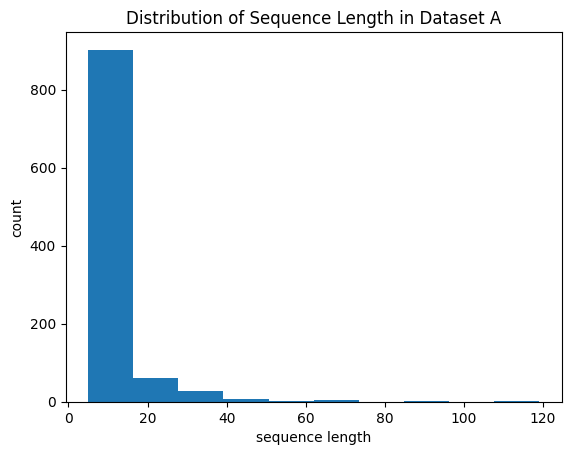

In [47]:
plt.hist(seq_lens_5)
plt.title('Distribution of Sequence Length in Dataset A')
plt.xlabel('sequence length')
plt.ylabel('count')
plt.show()

In [48]:
prod_freq_5 = beauty5['prod'].value_counts()
prod_freq_5.describe()

count    3069.000000
mean        3.091887
std         2.889314
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        24.000000
Name: count, dtype: float64

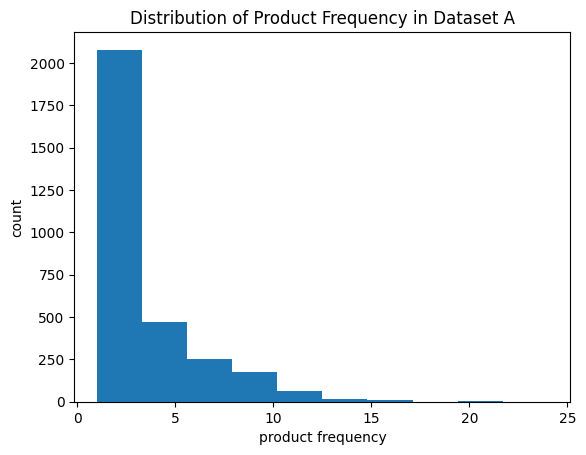

In [50]:
plt.hist(prod_freq_5)
plt.title('Distribution of Product Frequency in Dataset A')
plt.xlabel('product frequency')
plt.ylabel('count')
plt.show()

### higher product frequency (>= 7)

In [51]:
beauty7 = pd.read_csv('assets/beauty23_clean_7.csv')

In [52]:
seq_lens_7 = beauty7['usr'].value_counts()
seq_lens_7.describe()

count    860.000000
mean       9.140698
std        8.049612
min        5.000000
25%        5.000000
50%        6.000000
75%       10.000000
max       99.000000
Name: count, dtype: float64

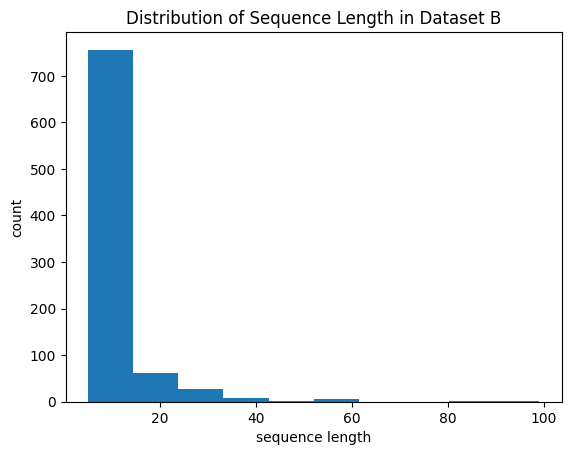

In [53]:
plt.hist(seq_lens_7)
plt.title('Distribution of Sequence Length in Dataset B')
plt.xlabel('sequence length')
plt.ylabel('count')
plt.show()

In [54]:
prod_freq_7 = beauty7['prod'].value_counts()
prod_freq_7.describe()

count    2394.000000
mean        3.283626
std         3.018429
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        24.000000
Name: count, dtype: float64

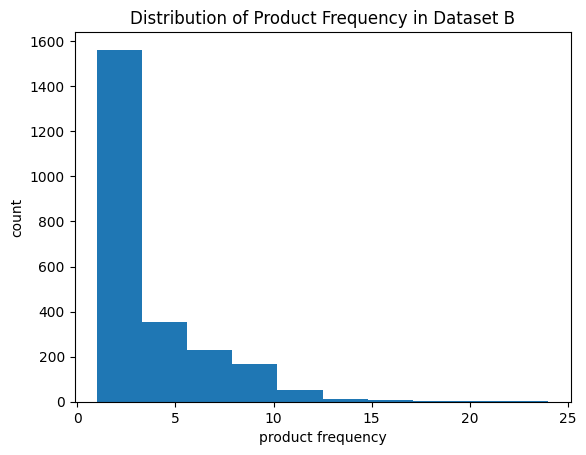

In [55]:
plt.hist(prod_freq_7)
plt.title('Distribution of Product Frequency in Dataset B')
plt.xlabel('product frequency')
plt.ylabel('count')
plt.show()